In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be

In [65]:
# Descarga de datos
# ==============================================================================
datos = pd.read_csv('b.csv')
datos['time'] = pd.to_datetime(datos['time'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('time')
datos = datos.asfreq('H')
datos = datos.sort_index()
datos

,generation biomass,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation solar,generation waste,generation wind onshore,temp,temp_min,temp_max,total load actual
time,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,863.0,1051.0,1899.0,7096.0,49.0,196.0,6378.0,"270.475,00",270.475,270.475,25385.0
2015-01-01 01:00:00+01:00,449.0,920.0,1009.0,1658.0,7096.0,50.0,195.0,5890.0,"270.475,00",270.475,270.475,24382.0
2015-01-01 02:00:00+01:00,448.0,1164.0,973.0,1371.0,7099.0,50.0,196.0,5461.0,"269.686,00",269.686,269.686,22734.0
2015-01-01 03:00:00+01:00,438.0,1503.0,949.0,779.0,7098.0,50.0,191.0,5238.0,"269.686,00",269.686,269.686,21286.0
2015-01-01 04:00:00+01:00,428.0,1826.0,953.0,720.0,7097.0,42.0,189.0,4935.0,"269.686,00",269.686,269.686,20264.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,297.0,1.0,1135.0,4836.0,6073.0,85.0,277.0,3113.0,282.14,281.15,283.15,30653.0
2018-12-31 20:00:00+01:00,296.0,1.0,1172.0,3931.0,6074.0,33.0,280.0,3288.0,282.15,282.15,282.15,29735.0
2018-12-31 21:00:00+01:00,292.0,50.0,1148.0,2831.0,6076.0,31.0,286.0,3503.0,284.15,284.15,284.15,28071.0


In [53]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2017-12-31 23:59:00'
fin_validacion = '2018-7-31 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2015-01-01 00:00:00+01:00 --- 2017-12-31 23:00:00+01:00  (n=26304)
Fechas validacion : 2018-01-01 00:00:00+01:00 --- 2018-07-31 23:00:00+01:00  (n=5088)
Fechas test       : 2018-08-01 00:00:00+01:00 --- 2018-12-31 23:00:00+01:00  (n=3672)


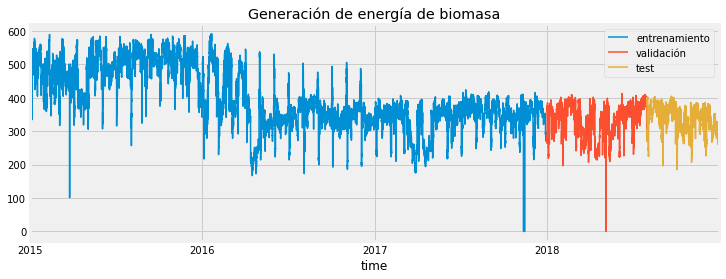

In [66]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['generation biomass'].plot(ax=ax, label='entrenamiento')
datos_val['generation biomass'].plot(ax=ax, label='validación')
datos_test['generation biomass'].plot(ax=ax, label='test')
ax.set_title('Generación de energía de biomasa')
ax.legend();

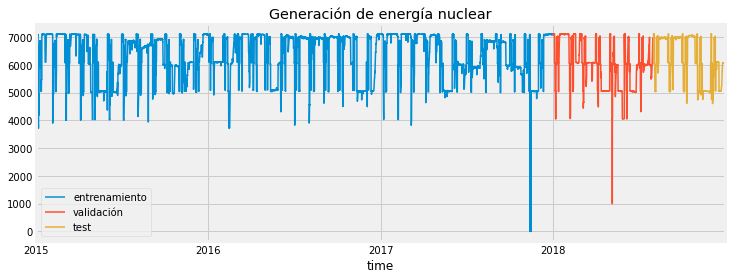

In [67]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['generation nuclear'].plot(ax=ax, label='entrenamiento')
datos_val['generation nuclear'].plot(ax=ax, label='validación')
datos_test['generation nuclear'].plot(ax=ax, label='test')
ax.set_title('Generación de energía nuclear')
ax.legend();

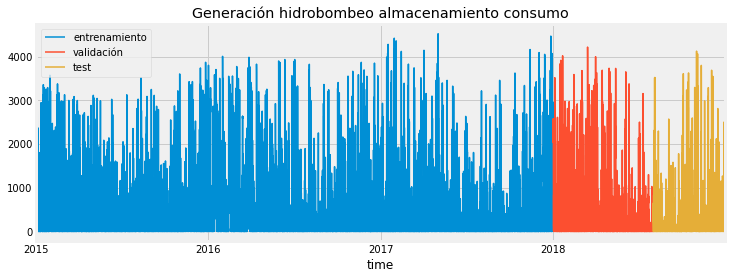

In [68]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['generation hydro pumped storage consumption'].plot(ax=ax, label='entrenamiento')
datos_val['generation hydro pumped storage consumption'].plot(ax=ax, label='validación')
datos_test['generation hydro pumped storage consumption'].plot(ax=ax, label='test')
ax.set_title('Generación hidrobombeo almacenamiento consumo')
ax.legend();

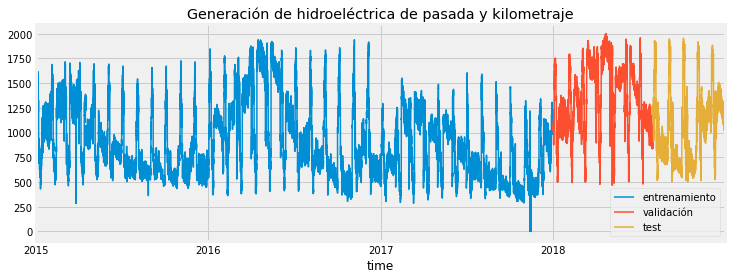

In [69]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['generation hydro run-of-river and poundage'].plot(ax=ax, label='entrenamiento')
datos_val['generation hydro run-of-river and poundage'].plot(ax=ax, label='validación')
datos_test['generation hydro run-of-river and poundage'].plot(ax=ax, label='test')
ax.set_title('Generación de hidroeléctrica de pasada y kilometraje')
ax.legend();

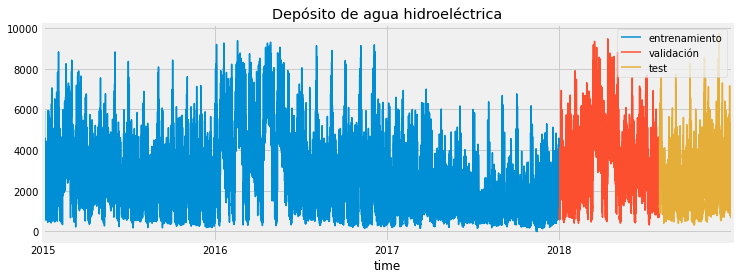

In [70]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['generation hydro water reservoir'].plot(ax=ax, label='entrenamiento')
datos_val['generation hydro water reservoir'].plot(ax=ax, label='validación')
datos_test['generation hydro water reservoir'].plot(ax=ax, label='test')
ax.set_title('Depósito de agua hidroeléctrica')
ax.legend();

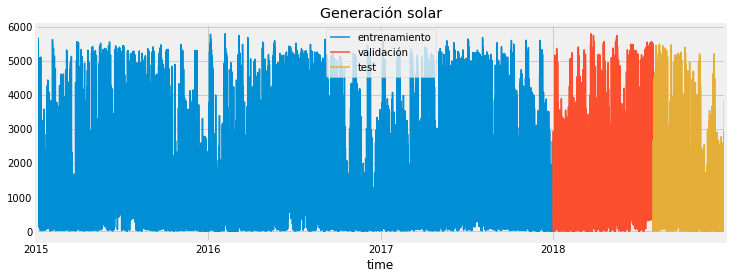

In [71]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['generation solar'].plot(ax=ax, label='entrenamiento')
datos_val['generation solar'].plot(ax=ax, label='validación')
datos_test['generation solar'].plot(ax=ax, label='test')
ax.set_title('Generación solar')
ax.legend();

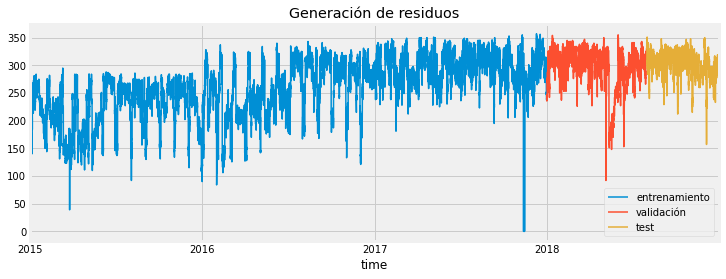

In [72]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['generation waste'].plot(ax=ax, label='entrenamiento')
datos_val['generation waste'].plot(ax=ax, label='validación')
datos_test['generation waste'].plot(ax=ax, label='test')
ax.set_title('Generación de residuos')
ax.legend();

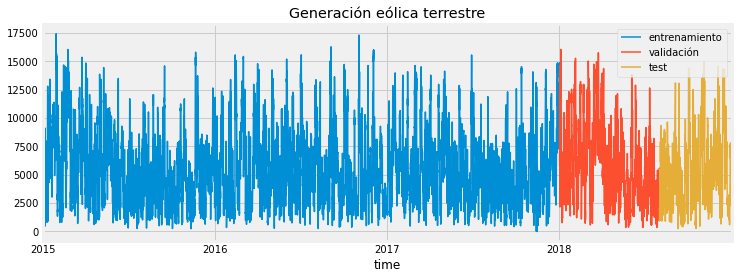

In [73]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['generation wind onshore'].plot(ax=ax, label='entrenamiento')
datos_val['generation wind onshore'].plot(ax=ax, label='validación')
datos_test['generation wind onshore'].plot(ax=ax, label='test')
ax.set_title('Generación eólica terrestre')
ax.legend();

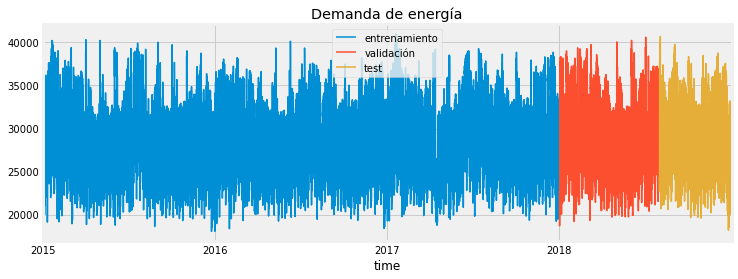

In [74]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['total load actual'].plot(ax=ax, label='entrenamiento')
datos_val['total load actual'].plot(ax=ax, label='validación')
datos_test['total load actual'].plot(ax=ax, label='test')
ax.set_title('Demanda de energía')
ax.legend();


In [75]:
#XBOOST
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'objective': 'reg:squarederror', 'base_score': None

In [76]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = datos.loc[:fin_validacion, 'total load actual'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 48


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [06:45<00:00, 101.33s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 5434879.003422106



In [77]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",5.434879e+06,0.1,10.0,100.0
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",5.668596e+06,0.1,10.0,500.0
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",6.109728e+06,0.1,5.0,500.0
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",6.117232e+06,0.1,5.0,100.0
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",6.214880e+06,0.1,10.0,500.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",6.311453e+06,0.1,5.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",6.508020e+06,0.1,10.0,100.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",6.649402e+06,0.1,3.0,500.0
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",6.708646e+06,0.1,5.0,100.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",6.839574e+06,0.1,5.0,500.0


In [80]:
print(backtesting_forecaster.__doc__)


    Backtesting of forecaster model.

    If `refit` is False, the model is trained only once using the `initial_train_size`
    first observations. If `refit` is True, the model is trained in each iteration
    increasing the training set. A copy of the original forecaster is created so 
    it is not modified during the process.

    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterAutoregCustom, ForecasterAutoregMultiOutput
        Forecaster model.
        
    y : pandas Series
        Training time series values. 
    
    initial_train_size: int, default `None`
        Number of samples in the initial train split. If `None` and `forecaster` is already 
        trained, no initial train is done and all data is used to evaluate the model. However, 
        the first `len(forecaster.last_window)` observations are needed to create the 
        initial predictors, so no predictions are calculated for them.

        `None` is only allowed when `refit` is False.

In [81]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['total load actual'],
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            steps              = 36,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False # Change to True to see detailed information
                       )

print(f"Error de backtest: {metric:.2f}")

Error de backtest: 5846150.77


In [82]:
# Predicciones test
# ==============================================================================
predicciones

,pred
2018-08-01 00:00:00+01:00,24736.058594
2018-08-01 01:00:00+01:00,23483.019531
2018-08-01 02:00:00+01:00,22730.285156
2018-08-01 03:00:00+01:00,22479.564453
2018-08-01 04:00:00+01:00,22597.623047
...,...
2018-12-31 19:00:00+01:00,32975.960938
2018-12-31 20:00:00+01:00,33095.554688
2018-12-31 21:00:00+01:00,32171.375000
2018-12-31 22:00:00+01:00,30231.968750


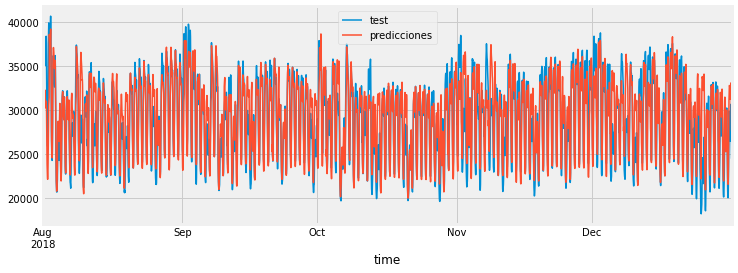

In [83]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['total load actual'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [85]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['total load actual'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
        data_frame = datos_plot.reset_index(),
        x      = 'date_time',
        y      = datos_plot.columns,
        title  = 'Demanda',
        width  = 900,
        height = 500
     )

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [86]:
# Cambio de las variables categóricas a tipo category
# ==============================================================================
datos['temp'] = datos['temp'].astype('category')